In [30]:
import autograd.numpy as anp
import numpy as np
from autograd import grad, elementwise_grad
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
import scipy.sparse.linalg as splinalg
from scipy import linalg
from pathlib import Path
# from scipy.stats import binomtest, binom_gen

## helper functions

In [31]:
def printmatrix(mat, **kwargs):
    fp = kwargs.get("fp", 3)
    format_dict = {
        'float_kind': lambda x: f"{x:>10.{fp}f}",
        'bool': lambda x: False if x == 0 else True,
        }
    formatter = kwargs.get("formatter", format_dict)
    linewidth = kwargs.get("linewidth", 110)
    with np.printoptions(formatter=formatter, linewidth=linewidth):
        print(mat)

<function unary_to_nary.<locals>.nary_operator.<locals>.nary_f at 0x000001D25291F420>
2.718281828459045
-0.0
-2.718281828459045


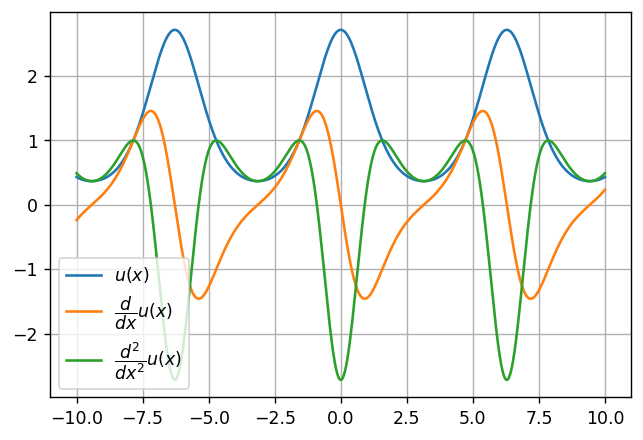

In [32]:
u = lambda x: anp.exp(anp.cos(x))

x = anp.linspace(-10, 10, 1001, dtype=anp.float64)
up = elementwise_grad(u)
upp = elementwise_grad(up)
print(up)
fig, ax = plt.subplots(dpi=125, figsize=(6,4))
ax.plot(x, u(x), label = "$u(x)$")
ax.plot(x, up(x), label = r"$\dfrac{d}{dx}u(x)$")
ax.plot(x, upp(x), label = r"$\dfrac{d^2}{dx^2}u(x)$")

ax.grid()
ax.legend()

for func in [u, up, upp]:
    print(func(0.))

# Exercise 2.a)


Solve the PDE with Dirichlet BC (DBC):
$$\begin{align*}
\epsilon u'' + u(u' - 1) = 0, &\quad 0\leq t \leq 1 \\
    u(0) = \alpha, &\quad u(1) = \beta
\end{align*}$$
with $\alpha = -1$, $\beta = 1.5$, and $\epsilon = 0.1$

## a) Derive 2nd-order accurate scheme

In [33]:
N = 10
a, b = 0, 1
h = (b - a) / N

# ts = np.arange(a, b+h, step=h)

def system(N):
    ones =  lambda n: np.ones(shape=(n,), dtype=np.float64)
    A = np.diag(ones(N-2), 1) + np.diag(ones(N-2), -1) + np.diag(-2*ones(N-1), 0)
    return A

def rhs2BV(b, BC):
    B = b
    alpha, beta = BC
    B[0] -= alpha
    B[-1] -= beta
    return B

print(F"{system(N) = }")
system(N)
print(F"{rhs2BV(np.zeros((N-1)), (-1, 1.5)) = }")
rhs2BV(np.zeros((N-1)), (-1, 1.5))


def solve2BV(N, BC, h):
    A = system(N)
    alpha, beta = BC
    f = np.ones((N-1))
    B = rhs2BV(f, (alpha/h**2, beta/h**2))
    return linalg.solve(A, B)

print(F"{solve2BV(10, (-1, 1.5), 1e-2) = }")

    

system(N) = array([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.]])
rhs2BV(np.zeros((N-1)), (-1, 1.5)) = array([ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1.5])
solve2BV(10, (-1, 1.5), 1e-2) = array([-7.50450e+03, -5.00800e+03, -2.51050e+03, -1.20000e+01,
        2.48750e+03,  4.98800e+03,  7.48950e+03,  9.99200e+03,
        1.24955e+04])


In [34]:
from sympy import init_session, factorial, summation, symbols, diff, Function, O, latex
from IPython.display import display, Math
# from scipy.special import factorial
init_session()

IPython console for SymPy 1.13.3 (Python 3.13.2-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.3/



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

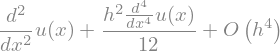

In [35]:
j, h, a = symbols("j h alpha")
u = Function("u")

def taylor(func, var, k, J):
    return sum( (J*h)**n / (factorial(n)) * diff(func(var), var, n) + O(h**(k+1)) for n in range(k+1))

u_m = taylor(u, x, 5, j-1)
u_p = taylor(u, x, 5, j+1)
u_0 = taylor(u, x, 5,  j )

res = (u_m - 2*u_0 + u_p) / h**2
def coeff(n):
    return ((j-1)**n - 2*j**n + (j+1)**n).simplify()

for n in range(6):
    display(Math(rf"\alpha_{n} =" + latex(coeff(n))))
display(res.subs(j, 0).simplify())
# sum(coeff(n) * h**n * diff(u(x), x, n) / factorial(n) for n in range(6)).subs(j, 1) / h**2

## b) Solve equation using Newton's method

$$\begin{align*}
    \epsilon u'' + u(u' -1) = 0, &\quad 0\leq t \leq 1, \\
    u(0) = \alpha, &\quad u(1) = \beta, \\
    \alpha = -1, \quad \beta = 1.5, &\quad \epsilon = 0.1
\end{align*}$$

We are told that we may use 
$$
    u(x) \approx x - \bar x + w_0\tanh{\left(\frac{w_0(x-\bar x)}{2\epsilon}\right)}
$$
for our initial guess.

First we note that, rewriting as we have described in our assignemnt task 2a. a), we have that 
$$\begin{align*}
    \epsilon u'' + u(u' -1) &= 0 \\
    \Rightarrow \epsilon \frac{U_{j-1} - 2U_j + U_{j+1}}{h^2} + U_j\left(\frac{U_{j+1} - U_{j-1}}{2h} - 1\right) &= 0 \\
    \Rightarrow F_j(U) &= 0
\end{align*}$$

Then, we define the jacobian as
$$ 
    J_{ij}(U) = \frac{\partial}{\partial U_j} F_i(U)
$$

we then have the non-zero derivatives
$$\begin{align*}
    \frac{\partial}{\partial U_{i-1}}F_i(U) &= \epsilon\frac{1}{h^2} - \frac{U_i}{2h} \\
    \frac{\partial}{\partial U_{i}}F_i(U) &= -2\epsilon \frac{1}{h^2} + \frac{U_{i+1} - U_{i-1}}{2h} - 1\\
    \frac{\partial}{\partial U_{i+1}}F_i(U) &= \epsilon\frac{1}{h^2} + \frac{U_i}{2h}
\end{align*}$$
assuming we have a $4\times 4$ matrix, such that, $i, j \in \{0, 3\}$

We get the jacobian

$$\begin{align*}
    J &= \begin{pmatrix}
        1 & 0 & 0 & 0 \\ 
        \frac{\epsilon}{h^2} - \frac{U_1}{2h} & -\frac{2\epsilon}{h^2} + \frac{U_{2} - U_{0}}{2h} - 1& \frac{\epsilon}{h^2} + \frac{U_1}{2h} & 0 \\
        0 & \frac{\epsilon}{h^2} - \frac{U_2}{2h} & -\frac{2\epsilon}{h^2} + \frac{U_3 - U_1}{2h} - 1 & \frac{\epsilon}{h^2} + \frac{U_2}{2h} \\
        0 & 0 & 0 & 1
    \end{pmatrix}
\end{align*}$$

### Define functions for Newton's method

In [36]:
def jacobian(U, epsilon, kwargs):
    """ Compute Jacobian for the equation 
    epsilon * u'' + u * (u' - 1) = 0
    using sparse-matrix
    
    Paramters
    ---
    U : ndarray of size `(N,)`
    epsilon : float  
        The value of the `epsilon` parameter
    kwargs : key-word-arguments for parameters to be used.  
        Includes:
            `{a, b} : {start, stop}` of the boundary  
            `{alpha, beta}` boundary values  
            `ts` values of the variable `t` to evaluate at
            `h` step size 
    Returns
    ---
    J : ndarray of size `(N, N)`
        the jcaobian of the specific problem
    """
    h = kwargs.get("h")
    N = kwargs.get("N")
    
    ####### The non-sparse calculations #######
    # # Initialized jacobian. First and last element in diagonal are set to 1, to avoid updating the boundary values, ensuring that BC hold.
    # J = np.zeros(shape=(N,N))
    # J[0,0] = 1
    # J[-1, -1] = 1
    
    # # The tri-diagonal is set
    # for i in range(1, N-1):
    #     J[i, i-1] = epsilon/(h**2) - U[i]/(2*h) 
    #     J[i, i] = -2*epsilon/(h**2) + (U[i+1] - U[i-1]) / (2*h) - 1
    #     J[i, i+1] = epsilon/(h**2) + U[i]/(2*h)
    ###########################################
    
    ## The sparse-matrix calculations
    
    # Construct diagonals of jacobian
    lower_diag = np.zeros(shape=(N-1,))
    main_diag  = np.zeros(shape=(N,))
    upper_diag = np.zeros(shape=(N-1,))
    
    lower_diag[:-1] = epsilon/(h**2) - U[1:-1]/(2*h)
    main_diag[1:-1] = -2*epsilon/(h**2) + (U[2:] - U[:-2])/(2*h) - 1
    upper_diag[1:] = epsilon/(h**2) + U[1:-1]/(2*h)
    
    # Ensure BC by setting J[0,0] = J[-1,-1] = 1 (they will not be changed when iterating)
    main_diag[0] = 1
    main_diag[-1] = 1
    
    # Construct Jacobian from diagonal arrays as a csc-sparse matrix
    J = diags([lower_diag, main_diag, upper_diag], offsets=[-1, 0, 1], shape=(N,N), format="csc")
    return J


def system(U, epsilon, kwargs):
    """ Compute the residuals of the system
    
    Paramters
    ---
    U : ndarray of size `(N,)`
    epsilon : float  
        The value of the `epsilon` parameter
    
    Returns
    ---
    F : ndarray of size `(N,)`
        the residuals of the system
    """
    # initialize array
    N = kwargs.get("N")
    alpha = kwargs.get("alpha")
    beta = kwargs.get("beta")
    h = kwargs.get("h")
    F = np.zeros(shape=(N, ))
    
    # Ensure BC 
    F[0] = U[0] - alpha 
    F[-1] = U[-1] - beta
    
    # Everything else is determined according to the stencil approximations
    for i in range(1, N-1):
        upp = (U[i+1] - 2*U[i] + U[i-1]) / (h**2)
        up = (U[i+1] - U[i-1]) / (2*h)
        F[i] = epsilon*upp + U[i]*(up - 1)
    
    return csc_matrix(F).T # Convert to sparse column vector


def Newton(u0, epsilon, max_iter, kwargs, tol):
    """Use Newtons method for iterative root-finding of the system, `F(U) = 0`.
    
    Update `U^[k+1] = U^[k] + DeltaU`.  
    
    Compute `J^[k+1]` and `F^[k+1]` from `U^[k+1]`.  
    
    Solve `J @ DeltaU = -F`.
    
    Check if `||F^[k]|| / ||F^[0]|| < epsilon` (converged)
    
    Parameters
    ---
    u0 : ndarray of size `(N,)`  
        The initial guess
    epsilon : float  
        The value of the `epsilon` parameter  
    max_iter : int
        Max number of iterations to run if the method did not converge.  
    tol : flaot 
        The tolerance for determining convergence. (Default = 1e-6)
    
    Returns 
    ---
    U : ndarray of size `(N,)`
        The array solving the system `F(U) = 0` 
    J : ndarray of size `(N, N)`
        The Jacobian for the last iteration - used for error estimation
    """
    # Make sure not to alter the input array itself.
    U = u0.copy()
    for i in range(max_iter):
        ## Some advanced print-statement for counting loops.
        print(f"Running loop   : {i+1:>{len(str(max_iter))+3},}/{max_iter:,}", end="\r")
        
        # define system array
        F = system(U, epsilon, kwargs) # CSC-matrix
        
        # save the first iteration for convergence test
        if i == 0:
            F0 = F.copy() 
        
        # Compute Jacobian
        J = jacobian(U, epsilon, kwargs) # CSC-matrix
                
        # Solve the (sparse-matrix) equation: J@DeltaU = -F
        DeltaU = spsolve(J, -F)
        
        # Update U^[k+1] = U^[k] + DeltaU
        U = U + DeltaU
        # print(f"||F||_oo: {splinalg.norm(F):.3e}")
        
        # Compute error : || DeltaU ||_{oo} < tol and break if converged
        rel_err = splinalg.norm(F, np.inf) / splinalg.norm(F0, np.inf)
        if (rel_err < tol) and (i+1 != max_iter):
            print() # avoid overwriting the Loop counter
            print(f"## Converged   : {rel_err:.3e} < tolerance")
            break
        elif i+1 == max_iter:
            print()
            print("did not converge...........")
    print()
    return U, J, F

### Run and plot Newton's method for decreasing values of $\epsilon$
Specify the parameters of the problem using the `kwargs` dictionary.

epsilon = 1
Running loop   :       4/3,000
## Converged   : 1.974e-09 < tolerance

epsilon = 0.1
Running loop   :       5/3,000
## Converged   : 2.943e-11 < tolerance

epsilon = 0.01
Running loop   :       4/3,000
## Converged   : 2.620e-12 < tolerance

epsilon = 0.001
Running loop   :       4/3,000
## Converged   : 1.023e-09 < tolerance



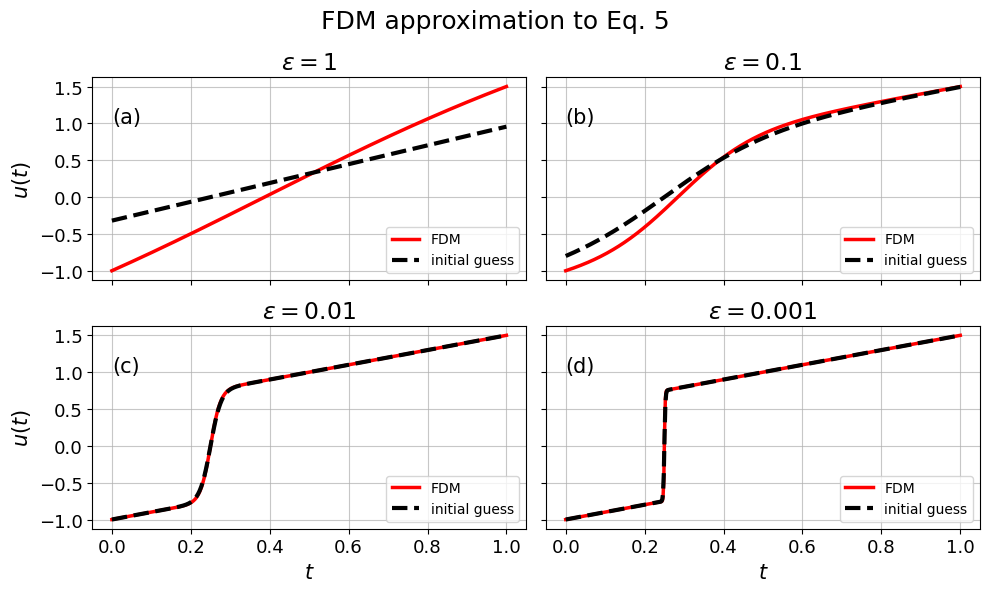

In [37]:

a, b = 0, 1 # boundary points
alpha, beta = -1, 1.5 # boundary values
N = 500 # Number of grid points


# Define initial guess u(t, epsilon)
tbar = 0.5 * (a + b - alpha - beta)
w0 = 0.5 * (a - b + beta - alpha)
u_init = lambda t, eps: t - tbar + w0 * np.tanh(w0*(t - tbar) / (2*eps))


# Define t-array of equidistant points
ts = np.linspace(a, b, num=N, endpoint=True)
h = np.abs(ts[0] - ts[1]) # step between grid-points 

kwargs = {
    "a": a,
    "b": b,
    "alpha": alpha,
    "beta": beta,
    "N": N,
    "ts": ts,
    "h": h,
}

LABELSIZE = 15
LABELS = ["(a)", "(b)", "(c)", "(d)"]
def plot_params(ax, subfig_label, label, labelsize):
    ax.set_title(label, size=labelsize+2)
    ax.legend(loc="lower right")
    ax.tick_params(axis='both', labelsize=labelsize-2)  # Set fontsize for both x and y ticks
    ax.text(0, 1, subfig_label, size=labelsize)
    ax.grid(alpha=0.7)
    
# Compute for different values of epsilon.
fig, ax = plt.subplots(2, 2, figsize=(10,6), sharey=True, sharex=True)
epsilon_list = [1, 0.1, 0.01, 0.001]
for i, epsilon in enumerate(epsilon_list):
    ax = ax.flatten() # flatten array: [[1, 2], [a, b]] --> [1, 2, a, b]
    print(f"{epsilon = }")
    y, *_ = Newton(u_init(ts, epsilon), epsilon, 3000, kwargs, tol=1e-6) # Run Newtons method
    ax[i].plot(ts, y, "r-", label="FDM", lw=2.5)
    ax[i].plot(ts, u_init(ts, epsilon), "k--", label=f"initial guess", lw=3)
    ax[i].set_yticks([-1, -0.5, 0, 0.5, 1, 1.5])
    if i in [0, 2]:
        ax[i].set_ylabel("$u(t)$", size=LABELSIZE)
    if i in [2, 3]:
        ax[i].set_xlabel("$t$", size=LABELSIZE)
    plot_params(ax[i], subfig_label=LABELS[i], label=fr"$\epsilon = {epsilon}$", labelsize=LABELSIZE)

fig.suptitle("FDM approximation to Eq. 5", fontsize=LABELSIZE+3)
fig.tight_layout()

# make directory if not already present
assignment_dir = Path.cwd() # directory for this working directory (if using notebook, it will be the direcotry of notebook)
figures_dir = assignment_dir / "figures" # figures directory
figures_dir.mkdir(parents=True, exist_ok=True) # create folder and parent directories, if not already existing.

file_name = "ex_2a.b.FMD.png"
fig.savefig(figures_dir / file_name, transparent=False)

### Estimate the global error and check convergence

#### Find solutions for different grid-sizes

In [57]:
a, b = 0, 1
alpha, beta = -1, 1.5
epsilon = 0.01

KWARGS = {
    "a": 0,
    "b": 1,
    "alpha": -1,
    "beta": 1.5,
}

# create list of : h, ts, u_h
solutions = []
N_list = [25, 50, 100, 200, 400, 800]
for N in N_list:
    print(f"{N = }")
    KWARGS["N"] = N
    KWARGS["ts"] = np.linspace(KWARGS["a"], KWARGS["b"], num=KWARGS["N"], endpoint=True)
    KWARGS["h"] = np.abs(KWARGS["ts"][0] - KWARGS["ts"][1]) 
    u_h, A_h, tau_h = Newton(u0=u_init(KWARGS["ts"], epsilon), 
                 epsilon=epsilon, max_iter=500, kwargs=KWARGS, tol=1e-8)
    
    solutions.append([KWARGS["h"], KWARGS["ts"], u_h, A_h, tau_h])
    
h_ref, t_ref, u_ref, A_ref, tau_ref = solutions[-1] # set the last solution (of finest grid) to be reference

N = 25
Running loop   :      5/500
## Converged   : 6.568e-09 < tolerance

N = 50
Running loop   :      4/500
## Converged   : 8.067e-09 < tolerance

N = 100
Running loop   :      4/500
## Converged   : 9.952e-13 < tolerance

N = 200
Running loop   :      4/500
## Converged   : 2.533e-13 < tolerance

N = 400
Running loop   :      4/500
## Converged   : 1.567e-12 < tolerance

N = 800
Running loop   :      4/500
## Converged   : 6.426e-12 < tolerance



#### Plot solutions for different `N`

In [58]:
# num_figs = len(solutions) - 1 
# # print(num_figs //2 + (num_figs % 2))
# nrows = (num_figs // 2) + (num_figs % 2) # Floor-division + residual
# fig, ax = plt.subplots(nrows, 2, figsize=(9, 9), sharex=True, sharey=False)
# ax = ax.flatten()
# for i, (h, t_h, u_h, A_h, tau_h) in enumerate(solutions[:-1]):
#     ax[i].plot(t_h, u_h, "o", label="$h$")
#     ax[i].plot(t_ref, u_ref, "r-", label="ref", lw=2)

#     ax[i].legend(loc="lower right")
#     ax[i].set_title(f"h = {h:.3e},   N = {len(t_h)}")
#     ax[i].grid()
    
#     if not (i % 2): # if even axis index
#         ax[i].set_ylabel("$u(t)$", size=LABELSIZE)
#     if i >= 2:
#         ax[i].set_xlabel("$t$", size=LABELSIZE)        
        
    
# fig.suptitle(f"$\\epsilon = {epsilon}$", size=(LABELSIZE + 3))
# fig.tight_layout()


##### How to sample (can be ignored)

In [59]:
# # Using searchsorted() to find indices of near-equal t-values
# h, ts_h, u_h = solutions[0]
# indices = np.searchsorted(ts_ref, ts_h)
# fig, ax = plt.subplots()
# ax.plot(ts_h, u_h, ".", label="h", markersize=8)
# ax.plot(ts_ref[indices], u_ref[indices], label="ref")
# ax.legend()

In [60]:
# # Using interp() to interpolate values of u_ref onto values for ts_h
# h, ts_h, u_h = solutions[0]
# u_interp = np.interp(ts_h, ts_ref, u_ref)
# fig, ax = plt.subplots()
# ax.plot(ts_h, u_h, ".", label="u_h", markersize=8)
# ax.plot(ts_h, u_interp, "-", label="u_interp")
# ax.legend()

In [61]:
# # Comparing the methods above
# fig, ax = plt.subplots(2,2, figsize=(10,6))
# ax = ax.flatten()
# for i, (h, ts_h, u_h) in enumerate(solutions[:-1]):
#     u_interp = np.interp(ts_h, ts_ref, u_ref)
#     indices = np.searchsorted(ts_ref, ts_h)
#     ax[i].plot(ts_ref[indices], u_ref[indices], "d", label="Indices method")
#     ax[i].plot(ts_h, u_interp, ".", label="Interpolation method")
#     ax[i].plot(ts_ref, u_ref, "k-", label="Reference", alpha=0.8)
#     plot_params(ax[i], subfig_label=LABELS[i], label=f"{h = :.2e},   N = {len(ts_h)}", labelsize=LABELSIZE)

# fig.suptitle(rf"$\epsilon = {epsilon}$", size=LABELSIZE+3)
# fig.tight_layout()

#### Find global error estimate

In [62]:
hs = []
error_vec = []

tau_norms = []
A_inv_norms = []
for i, (h, t_h, u_h, A_h, tau_h) in enumerate(solutions[:-1]):
    hs.append(h)
    tau_norm = linalg.norm(tau_h.toarray().flatten(), np.inf)
    # print(f"{tau_h.toarray().flatten().shape = }")
    tau_norms.append(tau_norm)
    
    # Get inverse by LU-factoriation
    lu = splinalg.splu(A_h)
    A_inv = lu.solve(np.eye(A_h.shape[0]))
    A_inv_norm = linalg.norm(A_inv, np.inf)
    A_inv_norms.append(A_inv_norm)
    
    indices = np.searchsorted(t_ref, t_h)
    u_sor = u_ref[indices]
    
    u_interp = np.interp(t_h, t_ref, u_ref)
    err = linalg.norm(u_h - u_sor, np.inf)
    error_vec.append(err)

hs = np.array(hs)
tau_norms = np.array(tau_norms)
error_vec = np.array(error_vec)
A_inv_norms = np.array(A_inv_norms)

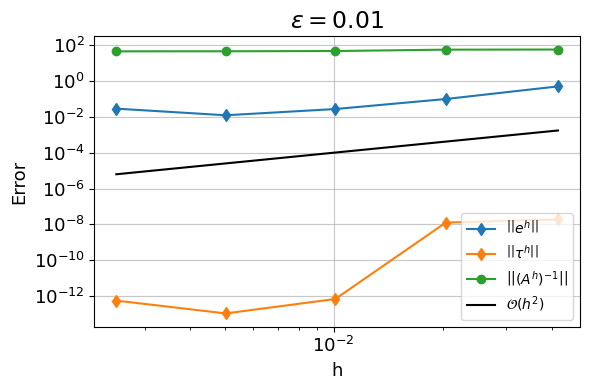

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(hs, error_vec, "d-", label=r"$\left|\left|e^h\right|\right|$")
ax.plot(hs, tau_norms, "d-", label=r"$\left|\left|\tau^h\right|\right|$")
ax.loglog(hs, A_inv_norms, "o-", label=r"$\left|\left|\left(A^h\right)^{-1}\right|\right|$")
ax.loglog(hs, hs**2, "k-", label=r"$\mathcal{O}(h^2)$", )
ax.set_title(rf"$\epsilon = {epsilon}$", size=LABELSIZE)
ax.set_ylabel("Error", size=LABELSIZE-2)
ax.set_xlabel("h", size=LABELSIZE-2)
# ax.set_xticks([1e-3, 1e-2, 1e-1])
plot_params(ax, "", fr"$\epsilon = {epsilon}$", LABELSIZE)
fig.tight_layout()

file_name = f"ex_2a.b_GEE_eps_{epsilon}.png"
fig.savefig(figures_dir / file_name, transparent=False)

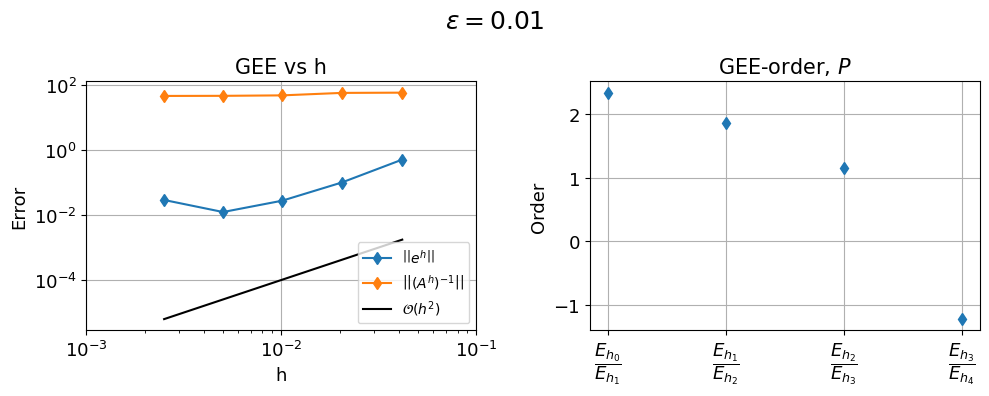

In [64]:
orders = [np.log2(error_vec[i] / error_vec[i+1]) for i in range(len(error_vec) - 1)]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].loglog(hs, error_vec, "d-", label=r"$\left|\left|e^h\right|\right|$")
# ax[0].loglog(hs, tau_norms, "d-", label=r"$\left|\left|\tau^h\right|\right|$")
ax[0].loglog(hs, A_inv_norms, "d-", label=r"$\left|\left|\left(A^h\right)^{-1}\right|\right|$")
ax[0].loglog(hs, hs**2, "k-", label=r"$\mathcal{O}(h^2)$")
ax[0].set_title("GEE vs h", size=LABELSIZE)
ax[0].set_ylabel("Error", size=LABELSIZE-2)
ax[0].set_xlabel("h", size=LABELSIZE-2)
ax[0].set_xticks([1e-3, 1e-2, 1e-1])
ax[0].legend()

ax[1].plot(orders, "d")
ax[1].set_title("GEE-order, $P$", size=LABELSIZE)
ax[1].set_ylabel(r"Order", size=LABELSIZE-2)
ax[1].set_xlabel("")
ax[1].set_xticks(range(len(error_vec) - 1))
ax[1].set_xticklabels([rf"$\dfrac{{ E_{{ h_{i} }} }}{{ E_{{ h_{i+1} }} }}$" for i in range(len(error_vec) - 1)])

for i, axis in enumerate(ax):
    axis.tick_params(axis="both", which="major", labelsize=LABELSIZE-2)
    axis.grid()

fig.suptitle(fr"$\epsilon = {epsilon}$", size=LABELSIZE+3)
fig.tight_layout()


file_name = f"ex_2a.b_GEE-order_eps_{epsilon}.png"
fig.savefig(figures_dir / file_name, transparent=False)

In [46]:
# 